In [ ]:
!pip install langchain langgraph cassio

In [ ]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:bZDIrMGcZMLLoQxWMPjNgmqu:a1b0a75ec6a9b5a3e1c0372677c09612fe5548d9e8cd013e8f60cdcb4a6799be" # enter the "AstraCS:..." string found in in your Token JSON file"
ASTRA_DB_ID="6d744a1b-5cd7-47a2-a6f5-cc8c4c396f1e"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [ ]:
!pip install langchain_community

In [ ]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [ ]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
   "https://www.policylink.org/"
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)



In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

In [ ]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 4 headlines.


In [ ]:
retriever=astra_vector_store.as_retriever()

In [ ]:
retriever.invoke("What is policy",ConsistencyLevel="LOCAL_ONE")

[Document(metadata={'language': 'en', 'source': 'https://www.policylink.org/', 'title': 'PolicyLink'}, page_content='PolicyLink\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\nSkip to main content\n\n\n \n\n\n\n\n\n\n\n\nLifting Up What Works®\n\n\n\n\n\n\nBack\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\nFederal Policy \n\nOur Work\n\n\nOur Work \n\nEquitable Economy\n\n\nEquitable Economy \n\nNational Equity Atlas \n\nBay Area Equity Atlas \n\nEquitable Recovery \n\nAdvancing Workforce Equity \n\nCorporate Racial Equity Advantage \n\n\n\nHealthy Communities of Opportunity\n\n\nHealthy Communities of Opportunity \n\nWinning on Equity \n\nHealth Equity \n\nHousing \n\nInfrastructure \n\nWater Equity and Climate Resilience \n\n\n\n\n\nResources\n\n\nResources \n\nPublications \n\nNews & Opinion \n\nWebinars \n\nPodcast \n\nTools \n\nMedia Room \n\nThe Curb-Cut Effect \n\nCovid & Race Commentaries \n\nEquity Summits \n\n\n\nAbout\n\n\nAbout \n\nThe Equity Manifesto \n\nMission Statement \n\nStaff \n\nBoard 

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=userdata.get('groq_api_key')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to policies different types of policies of some corporation.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "what is policy"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'
datasource='vectorstore'


In [ ]:
!pip install langchain_community
!pip install arxiv wikipedia

In [ ]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [ ]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [ ]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [ ]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

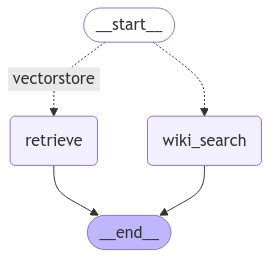

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
What is agent?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Intelligent agent\nSummary: In intelligence and artificial intelligence, an intelligent agent (IA) is an agent that perceives its environment, takes actions autonomously in order to achieve goals')


In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "who is blair waldorf"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
who is blair waldorf
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Blair Waldorf\nSummary: Blair Cornelia Waldorf (married name Bass) is one of the main characters of Gossip Girl, introduced in the original series of novels and also appearing as the lead in the ')
